# Práctica 5: Ejemplos de aplicación de algortimos de Machine Learning

**Ingeniería Electrónica**

**Inteligencia Artificial**

**28/06/2020**

# 1. Árboles de decisión para diagnosticar cáncer de seno (mama) 

Luego de haber revisado algunos métodos de Machine Learning, analizar un conjunto de datos real: el dataset de **_Breast Cancer Wisconsin_** (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

Este conjunto de datos es un resultado de la investigación de imágenes médicas, y hoy se considera un ejemplo clásico. El conjunto de datos se creó a partir de imágenes digitalizadas de tejidos sanos (benignos) y cancerosos (malignos). Las imágenes se verían similares a la siguiente:

<img src="ejemplo_img.png">

Los investigadores realizaron la **extracción de características** en las imágenes. Pasaron por un total de 569 imágenes y extrajeron 30 características diferentes que describen las características de los núcleos celulares presentes en las imágenes, que incluyen:

* textura del núcleo celular (representada por la desviación estándar de los valores de la escala de grises)
* tamaño del núcleo celular (calculado como la media de las distancias desde el centro a los puntos en el perímetro)
* suavidad del tejido (variación local en longitudes de radio)
* compacidad tisular

El **objetivo** de la investigación fue clasificar las muestras de tejido en benignas y malignas (una tarea de **clasificación binaria**).

## Cargar el conjunto de datos
El conjunto de datos completo es parte de los conjuntos de datos de ejemplo de Scikit-Learn:

In [3]:
from sklearn.datasets import load_breast_cancer
import graphviz
import pydotplus
import pydot
data = load_breast_cancer()

Todos los datos están contenidos en una matriz de datos 2D `data.data`, donde las filas representan muestras de datos y las columnas son los valores de las características:

In [4]:
data.data.shape

(569, 30)

Revisando los nombres de las características, reconocemos algunos de los que mencionamos anteriormente:

In [5]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

Dado que esta es una tarea de clasificación binaria, esperamos encontrar exactamente dos nombres como objetivo:

In [6]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

In [8]:
 X_train.shape, X_test.shape

((455, 30), (114, 30))

## Construyendo el árbol de decisión

In [9]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()

In [10]:
dtc.fit(X_train, y_train)
dtc

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Como no especificamos ningún parámetro previo, esperaríamos que este árbol de decisión crezca bastante y resulte en una puntuación perfecta en el conjunto de entrenamiento:

In [11]:
dtc.score(X_train, y_train)

1.0

El error de prueba tampoco es malo:

In [12]:
dtc.score(X_test, y_test)

0.9385964912280702

### Visualización del árbol

In [13]:
import graphviz

In [14]:
with open("tree.dot", 'w') as f:
        f = tree.export_graphviz(dtc, out_file=f,
                                 feature_names=data.feature_names,
                                 class_names=data.target_names)
!dot -Tpng tree.dot -o tree.png

from IPython.display import Image
Image("tree.png")

"dot" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


FileNotFoundError: No such file or directory: 'tree.png'

FileNotFoundError: No such file or directory: 'tree.png'

<IPython.core.display.Image object>

### Evaluación del modelo
Declaramos la función `mostrar_resultados` que genere un reporte de los resultados del modelo incluyendo la matriz de confusión.

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix, xticklabels=data.target_names, yticklabels=data.target_names, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

Llamamos a la función luego correr la predicción del modelo:

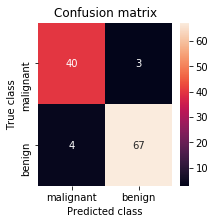

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        43
           1       0.96      0.94      0.95        71

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



In [16]:
y_pred = dtc.predict(X_test)
mostrar_resultados(y_test, y_pred)

In [17]:
# Puntaje por defecto es la exactitud
dtc.score(X_test, y_test)

0.9385964912280702

Obtener el área bajo la curva ROC, la cual una metrica más conservadora. La curva ROC es un gráfico de la tasa positiva verdadera versus la tasa positiva falsa en varios umbrales de probabilidad que van de 0 a 1.

In [18]:
from sklearn.metrics import roc_auc_score
prediction_prob = dtc.predict_proba(X_test)
pos_prob = prediction_prob[:, 1]

roc_auc_score(y_test, pos_prob)

0.9369472649852605

Codifiquemos y exhibamos la curva ROC (bajo los umbrales de 0.0, 0.1, 0.2, ..., 1.0) de nuestro modelo:

In [19]:
import numpy as np
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            # si real y predicion son 1
            if y == 1:
                true_pos[i] += 1
                # si real es 0 mientras que la prediccion es 1
            else:
                false_pos[i] += 1
        else:
            break

Luego calcular las tasas de verdadero y falso positivo para todas las configuraciones de umbral (recordar que hay 71 muestras benignas y 43 malignas):

In [20]:
true_pos_rate = [tp / 71.0 for tp in true_pos]
false_pos_rate = [fp / 43.0 for fp in false_pos]

Ahora podemos trazar la curva ROC con matplotlib:

No handles with labels found to put in legend.


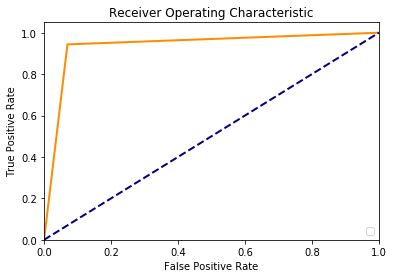

In [21]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Varios modelos
Ahora queremos hacer una exploración modelos. Por ejemplo, la profundidad de un árbol influye en su rendimiento. Si quisiéramos estudiar esta dependencia de manera más sistemática, podríamos repetir la construcción del árbol para diferentes valores de `max_depth`:

In [22]:
import numpy as np
max_depths = np.array([1, 2, 3, 5, 7, 9, 11])

Para cada uno de estos valores, queremos ejecutar modelo completo de principio a fin. También queremos guardar los puntajes del entramiento y  de la prueba. Hacemos esto en un bucle for:

In [23]:
train_score = []
test_score = []
for d in max_depths:
    dtc = tree.DecisionTreeClassifier(max_depth=d, random_state=42)
    dtc.fit(X_train, y_train)
    train_score.append(dtc.score(X_train, y_train))
    test_score.append(dtc.score(X_test, y_test))

Podemos trazar los puntajes en función de la profundidad del árbol usando Matplotlib:

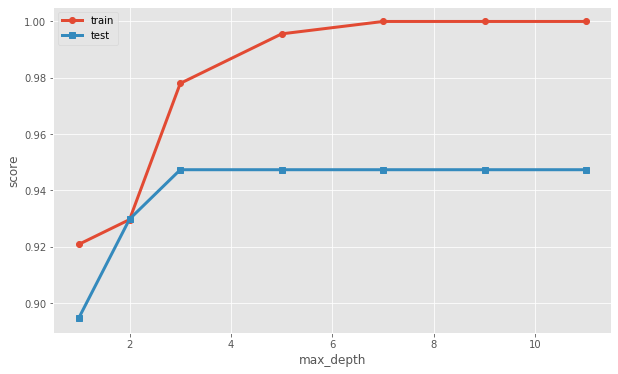

In [24]:
# import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_score, 'o-', linewidth=3, label='train')
plt.plot(max_depths, test_score, 's-', linewidth=3, label='test')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend()

Se hace evidente cómo la profundidad del árbol influye en el rendimiento. Parece que cuanto más profundo es el árbol, mejor es el rendimiento en el conjunto de entrenamiento. 
Desafortunadamente, las cosas parecen un poco más confusas cuando se trata del rendimiento del conjunto de prueba. Aumentar la profundidad más allá del valor 3 no mejora aún más el puntaje de la prueba. ¿Quizás hay una configuración diferente de la que podríamos aprovechar que funcionaría mejor?

¿Qué pasa con el número mínimo de muestras requeridas para hacer de un nodo un nodo hoja?

Repetimos el procedimiento de arriba:

In [25]:
train_score = []
test_score = []
min_samples = np.array([2, 4, 8, 16, 32])
for s in min_samples:
    dtc = tree.DecisionTreeClassifier(min_samples_leaf=s, random_state=42)
    dtc.fit(X_train, y_train)
    train_score.append(dtc.score(X_train, y_train))
    test_score.append(dtc.score(X_test, y_test))

Esto lleva a una gráfica diferente de la anterior:

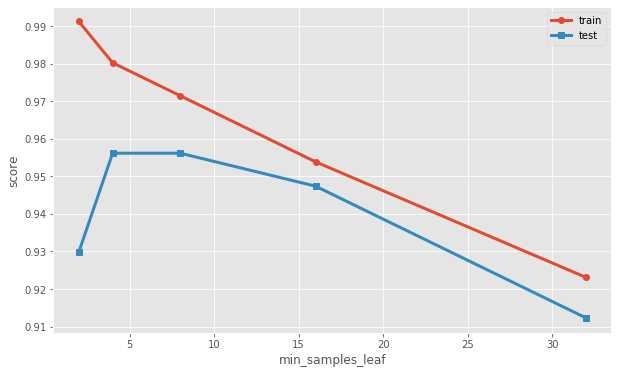

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(min_samples, train_score, 'o-', linewidth=3, label='train')
plt.plot(min_samples, test_score, 's-', linewidth=3,label='test')
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.legend()

Claramente, aumentar `min_samples_leaf` no aparenta bien con el puntaje de entrenamiento. **Pero eso no es necesariamente algo malo**, porque sucede algo interesante en la curva azul: el puntaje de prueba pasa por un máximo para valores entre 4 y 8, lo que lleva a un mejor puntaje de prueba que hemos encontrado hasta ahora: mayor a 95%.
Acabamos de aumentar nuestra puntuación inicial, simplemente ajustando los (hiper) parámetros del modelo.

## Ejercicio  

Una gran cantidad de buenos resultados en Machine Learning en realidad provienen de largas horas de exploraciones de modelos mediante prueba y error. Antes de generar una nueva gráfica, piensen en: ¿Cómo se esperaría que se vea la gráfica? ¿Cómo debería cambiar el puntaje de entrenamiento al comenzar a restringir el número de nodos hoja (**max_leaf_nodes**)? ¿Qué pasa con **min_samples_split**? Además, ¿cómo cambian las cosas cuando se cambia del índice de **Gini** a  ganancia de información (**information gain**)?

#### Numero de nodos hoja

In [27]:
train_score1 = []
test_score1 = []
max_l_n = np.array([1, 4, 8, 13,19])
for ln in max_l_n:
    dtc = tree.DecisionTreeClassifier(max_leaf_nodes=ln, random_state=42)
    dtc.fit(X_train, y_train)
    train_score1.append(dtc.score(X_train, y_train))
    test_score1.append(dtc.score(X_test, y_test))

ValueError: max_leaf_nodes 1 must be either None or larger than 1

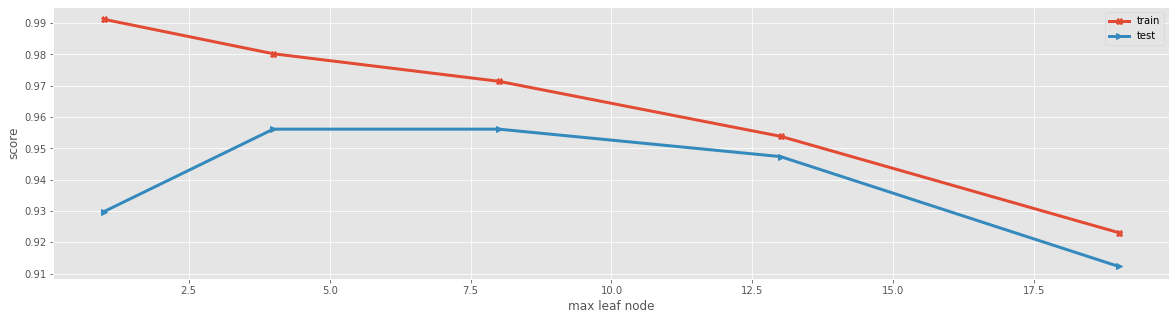

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(max_l_n, train_score, 'X-', linewidth=3, label='train')
plt.plot(max_l_n, test_score, '>-', linewidth=3,label='test')
plt.xlabel('max leaf node')
plt.ylabel('score')
plt.legend()

Se puede ver que el puntaje maximo se encuentra entre 5 y 6

### Numero minimo para dividir un nodo

In [29]:
train_score2 = []
test_score2 = []
min_s_s = np.array([4, 5, 6, 7, 8])
for ss in min_s_s:
    dtc = tree.DecisionTreeClassifier(min_samples_split=ss, random_state=42)
    dtc.fit(X_train, y_train)
    train_score2.append(dtc.score(X_train, y_train))
    test_score2.append(dtc.score(X_test, y_test))

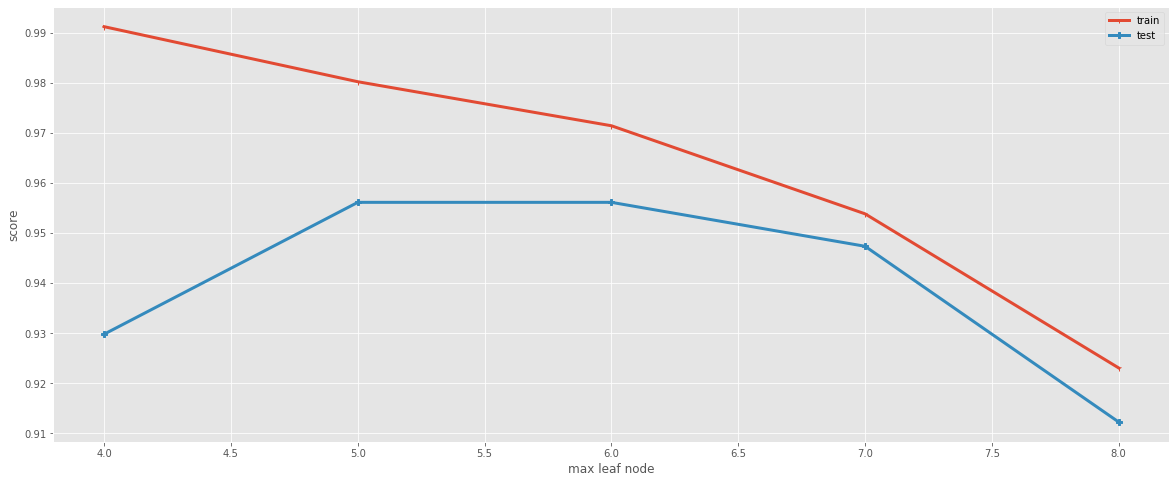

In [31]:
plt.figure(figsize=(20, 8))
plt.plot(min_s_s, train_score, '1-', linewidth=3, label='train')
plt.plot(min_s_s, test_score, 'P-', linewidth=3,label='test')
plt.xlabel('max leaf node')
plt.ylabel('score')
plt.legend()

Se puede ver que el puntaje maximo se encuentra entre 5 y 6

## Indice de Ganancia 

In [32]:
dtc2 = tree.DecisionTreeClassifier(criterion='entropy')
dtc2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [33]:
dtc2.score(X_train, y_train)

1.0

In [34]:
dtc2.score(X_test, y_test)

0.9473684210526315

In [35]:
with open("tree.dot", 'w') as f:
        f = tree.export_graphviz(dtc2, out_file=f,
                                 feature_names=data.feature_names,
                                 class_names=data.target_names)
!dot -Tpng tree.dot -o tree.png

from IPython.display import Image
Image("tree.png")

"dot" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


FileNotFoundError: No such file or directory: 'tree.png'

FileNotFoundError: No such file or directory: 'tree.png'

<IPython.core.display.Image object>

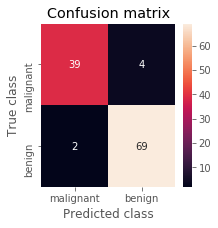

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        43
           1       0.95      0.97      0.96        71

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [36]:
y_pred = dtc2.predict(X_test)
mostrar_resultados(y_test, y_pred)

Empleando el indice de entropia genera una mejor presicion 